In [55]:
import os
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
from tqdm import tqdm

Preprocessing Librosa

In [56]:
TARGET_DURATION = 4.0      # durasi audio yang diseragamkan
TARGET_SR = 22050          # sample rate standar
N_MELS = 128               # ukuran mel-power
TARGET_FRAMES = 128        # output spectrogram: (128 mel × 128 time)

Load, Cut, Pad Audio

In [57]:
import librosa
import numpy as np

def load_and_segment_audio(path, duration=3.0, hop=1.5, sr=16000, n_mels=128):
    """
    Memotong audio menjadi beberapa segmen dengan sliding window.
    """
    audio, _ = librosa.load(path, sr=sr)
    
    segment_length = int(duration * sr)
    hop_length = int(hop * sr)

    segments = []

    # Lakukan sliding window
    for start in range(0, len(audio) - segment_length + 1, hop_length):
        segment = audio[start:start + segment_length]
        mel = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=1024, hop_length=512)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Normalisasi 0–1
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())

        # Resize ke 128×128
        mel_db = np.resize(mel_db, (128,128))

        segments.append(mel_db)

    return segments


Convert to MEL-Spectrogram (128 × 128)

In [58]:
import random

def spec_augment(mel_spectrogram, 
                 num_mask_freq=2, 
                 num_mask_time=2, 
                 freq_mask_size=15,
                 time_mask_size=20):
    """
    Melakukan SpecAugment pada spectrogram 128×128
    """
    mel = mel_spectrogram.copy()

    # FREQUENCY MASKING
    for _ in range(num_mask_freq):
        f = random.randint(0, freq_mask_size)
        f0 = random.randint(0, mel.shape[0] - f)
        mel[f0:f0+f, :] = 0

    # TIME MASKING
    for _ in range(num_mask_time):
        t = random.randint(0, time_mask_size)
        t0 = random.randint(0, mel.shape[1] - t)
        mel[:, t0:t0+t] = 0

    return mel

Load Folder Dataset Otomatis (Folder per Label)

In [59]:
import os

def load_dataset_with_sliding(base_path="dataset", use_specaug=True):
    X = []
    y = []
    
    labels = sorted(os.listdir(base_path))
    label_to_idx = {label: i for i, label in enumerate(labels)}

    for label in labels:
        folder = os.path.join(base_path, label)
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                filepath = os.path.join(folder, file)

                # Ambil banyak segmen hasil sliding window
                segments = load_and_segment_audio(filepath)

                for mel in segments:
                    if use_specaug:
                        mel = spec_augment(mel)

                    X.append(mel)
                    y.append(label_to_idx[label])

    X = np.array(X).reshape(-1, 128,128,1)
    y = np.array(y)

    return X, y, label_to_idx

Load Semua Dataset & Auto Label & Train-Test Split

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization, Dropout,
    Reshape, LSTM, Dense, Flatten, Input
)
from tensorflow.keras.optimizers import Adam

In [62]:
num_classes = len(label_map)

CRNN Architecture
(CNN + LSTM) + Compile Model

In [63]:
def build_continual_crnn(input_shape=(128,128,1), num_classes=num_classes):
    inputs = Input(shape=input_shape)

    # ----- FEATURE EXTRACTOR -----
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.4)(x)

    # Now: x = (16, 16, 128)
    # Convert to sequence: (16 timesteps, 2048 features)
    x = Reshape((16, 16*128))(x)
    # x = (16, 2048)

    # ----- RNN LAYER -----
    x = LSTM(256, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # ----- CLASSIFIER HEAD -----
    classifier = Dense(256, activation='relu')(x)
    classifier = Dropout(0.3)(classifier)
    outputs = Dense(num_classes, activation='softmax')(classifier)

    model = Model(inputs, outputs)

    # Freeze feature extractor (all Conv layers)
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            layer.trainable = False

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(0.0005),
        metrics=['accuracy']
    )

    return model

model = build_continual_crnn()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 16, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,523,535 (9.63 MB)

 Trainable params: 2,430,415 (9.27 MB)

 Non-trainable params: 93,120 (363.75 KB)

In [64]:
history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 50,
    batch_size = 32
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.0986 - loss: 2.7646 - val_accuracy: 0.0667 - val_loss: 2.7018
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 900ms/step - accuracy: 0.2042 - loss: 2.5036 - val_accuracy: 0.2000 - val_loss: 2.6560
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 911ms/step - accuracy: 0.2183 - loss: 2.5229 - val_accuracy: 0.2333 - val_loss: 2.5959
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 908ms/step - accuracy: 0.2394 - loss: 2.3797 - val_accuracy: 0.2000 - val_loss: 2.5474
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 947ms/step - accuracy: 0.2817 - loss: 2.3418 - val_accuracy: 0.1000 - val_loss: 2.5723
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 929ms/step - accuracy: 0.2817 - loss: 2.2277 - val_accuracy: 0.1000 - val_loss: 2.5310
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 902ms/step - accuracy: 0.2676 - loss: 2.2493 - val_accuracy: 0.1667 - val_loss: 2.4779
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 907ms/step - accuracy: 0.2535 - loss: 2.3364 - val_accuracy: 0.1667 - val_loss: 2

Evaluasi Model

In [65]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.3548 - loss: 1.9820
Test Accuracy: 0.35483869910240173


Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


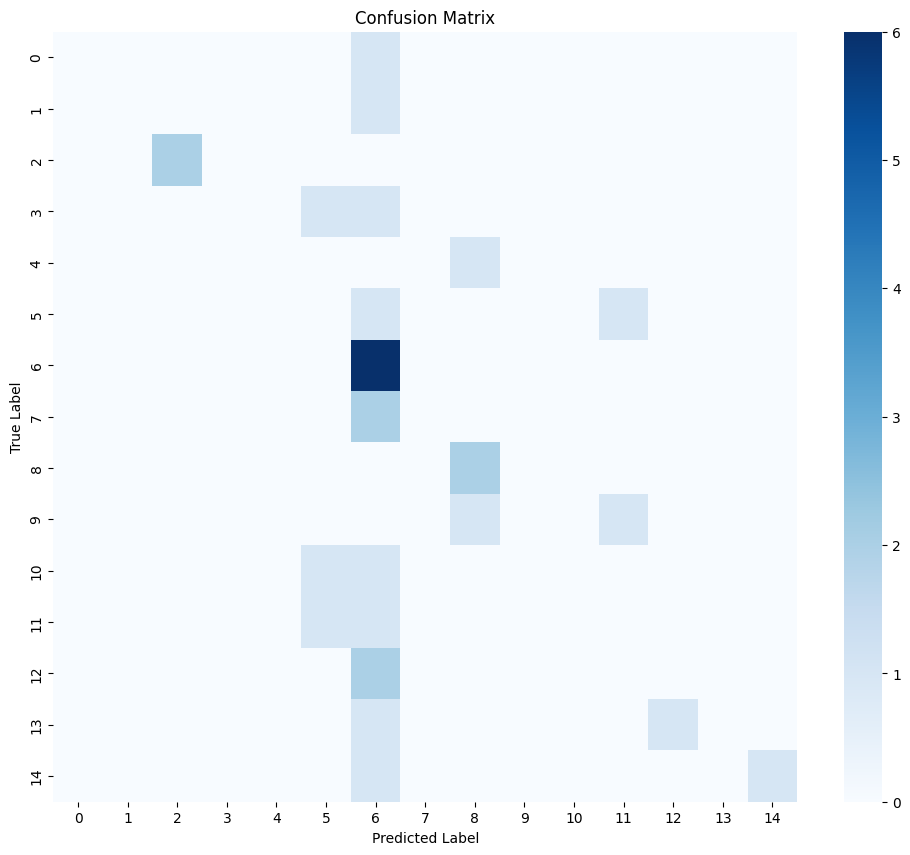

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [67]:
model.save("CRNN_Model.h5")